In [15]:
%matplotlib inline
import sys, os, time
from itertools import product

import rasterio as rio
import rasterio.mask as masker
import rasterio.plot as rplt
import rasterio.features
import rasterio.warp
import rasterio.windows as wnd

import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [22]:
def plot_shape(shape):
    figsize = (10,6)
    sns.set(style="whitegrid", palette="pastel", color_codes=True)
    sns.mpl.rc("figure", figsize=figsize)
    plt.figure(figsize = figsize)
    x = [i[0] for i in biggest.points]
    y = [i[1] for i in biggest.points]
    plt.plot(x, y, 'k')
    plt.show()
    
def get_tiles(dataset, width=512, height=512):
    ncols, nrows = dataset.meta['width'], dataset.meta['height']
    offsets = product(range(0, ncols, width), range(0, nrows, height))
    big_window = wnd.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    
    for col_off, row_off in offsets:
        window = wnd.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = wnd.transform(window, dataset.transform)
        yield window, transform

def get_tile(dataset, width=512, height=512, col_off=0, row_off=0):
    ncols, nrows = dataset.meta['width'], dataset.meta['height']
    offsets = product(range(0, ncols, width), range(0, nrows, height))
    big_window = wnd.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    
    window = wnd.Window(col_off=col_off * width, row_off=row_off * height, width=width, height=height).intersection(big_window)
    transform = wnd.transform(window, dataset.transform)
    with 

In [17]:
landsatTileList = r"/home/dsa/DSA/images/scene_list.txt"
landsatDirectory = r"/home/dsa/DSA/images/LC08_L1GT_209117_20140101_20170427_01_T2"
coastMaskShpfile = r"/home/dsa/DSA/vectors/Coastline_high_res_polygon_v7.1.shp"

outputDirectory = r"/home/dsa/DSA/vectors/"
outputFileExt = r"_burjo_output.tif"

assert os.path.isfile(landsatTileList)
assert os.path.isdir(landsatDirectory)
assert os.path.isfile(coastMaskShpfile)

In [4]:
tiles = open(landsatTileList).read().splitlines()
print(tiles)

['LC08_L1GT_209117_20140101_20170427_01_T2']


In [5]:
startTime = time.ctime()

In [6]:
print("ArcPy Rock masking script started: %s" % startTime)

ArcPy Rock masking script started: Mon Oct 14 07:50:05 2019


shapefile Reader
    14601 shapes (type 'POLYGON')
    14601 records (3 fields)


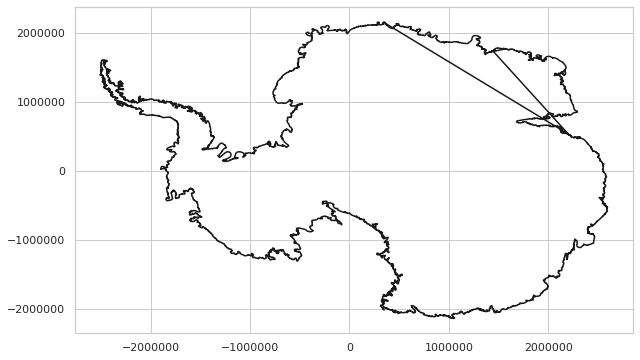

In [21]:
coast = shp.Reader(coastMaskShpfile)
print(coast)

biggest = max(coast.shapes(), key=lambda x: len(x.points))

plot_shape(biggest)

In [18]:
for i in range(len(tiles)):
    
    thisTileID = tiles[i]
    thisTileFile = landsatDirectory + "/" + thisTileID
    outFilename = outputDirectory + "/" + thisTileID
    
    fmt = "\t%d of %d."
    print(fmt % (i + 1, len(tiles)))
    tic = time.time()

	1 of 1.


Window(col_off=0, row_off=0, width=512, height=512)


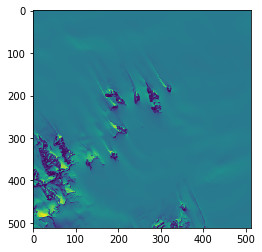

'    \nwith rio.open(thisTileFile + "_B3.TIF", dtype=\'float32\').read(1) as B3: # Green\n    pass\nwith rio.open(thisTileFile + "_B5.TIF", dtype=\'float32\').read(1) as B5: # NIR\n    pass\nwith rio.open(thisTileFile + "_B6.TIF", dtype=\'float32\').read(1) as B6: # SWIR1\n    pass\nwith rio.open(thisTileFile + "_B10.TIF", dtype=\'float32\').read(1) as B10: # TIRS1\n    pass\n'

In [34]:
with rio.open(thisTileFile + "_B2.TIF", dtype='float32') as B2_data: # Blue
    meta = B2_data.meta.copy()
    tile, transform = get_tile(B2_data, col_off=11, row_off=12)
    print(window)
    meta['transform'] = transform
    meta['width'], meta['height'] = window.width, window.height
    B2 = B2_data.read(window=tile)
rplt.show(B2)
"""    
with rio.open(thisTileFile + "_B3.TIF", dtype='float32').read(1) as B3_data: # Green
    pass
with rio.open(thisTileFile + "_B5.TIF", dtype='float32').read(1) as B5_data: # NIR
    pass
with rio.open(thisTileFile + "_B6.TIF", dtype='float32').read(1) as B6_da: # SWIR1
    pass
with rio.open(thisTileFile + "_B10.TIF", dtype='float32').read(1) as B10: # TIRS1
    pass
"""

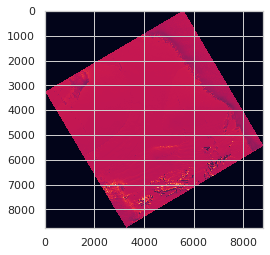

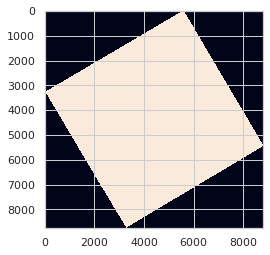

In [28]:
coastMask, coast_transform = masker.mask(B2, coast.shapes(), crop=True)
rplt.show(coastMask)
coastMaskBin = coastMask > 0
rplt.show(coastMaskBin)

In [31]:
toc = time.time()
print(" Loaded & Coast Masked (%.02fs)." % (toc - tic))
tic = time.time()

 Loaded & Coast Masked (1218.23s).


/home/dsa/Documents/project/AntarcticRockOutcrop/antrock/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


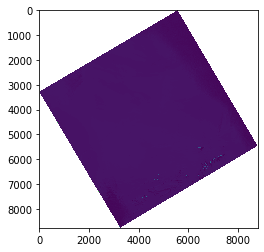

In [12]:
ndsi = (B3 - B6) / (B3 + B6)
rplt.show(ndsi)

In [13]:
ndwi = (B3 - B5) / (B3 + B5)
rplt.show(ndwi)

MemoryError: Unable to allocate array with shape (8761, 8801) and data type float64

In [ ]:
mask1_step1 = (B10 / B2) > 0.4
mask1_step2 = ndsi < 0.75
mask1_step3 = ndwi < 0.45
mask1_step5 = B10 > 2550 # Note: this is a scaled value

